In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### This page is a simple demonstration of Locally Weighted Regresssion (LOWESS)

I'm going to generate some data to use for this demonstration. I'll plot $$f(x) = x^3$$ with some additional noise.

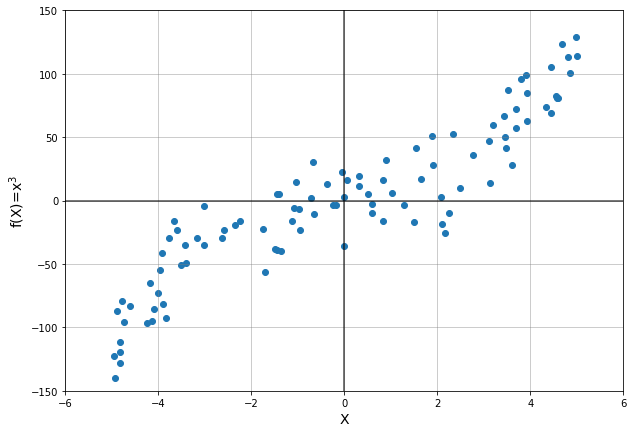

In [27]:
# generate data
X = np.random.uniform(low=-5,high=5,size=100) # random numbers between -5 and 5
y = (X**3) + 20 * np.random.normal(size=len(X)) # x cubed with random noise 

# So the data looks like this: 

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(X,y)

ax.hlines(y=0,xmin=-6,xmax=6, color='black',alpha=.7)
ax.vlines(x=0,ymin=-150,ymax=150, color='black',alpha=.7)

plt.ylim(-150,150)
plt.xlim(-6,6)

plt.xlabel('X',fontsize=14)
plt.ylabel('f(X)=x$^3$', fontsize=14)

ax.grid(which='major', color='grey', alpha = .5)

plt.show()

While we know that this data follows the cubed function, upon first glance we might be tempted to say it is merely a positive, linear relationship. 

Let's test that theory with a linear regression model.

As a reminder, linear regression is simply solving for the weights $\beta$ of a linear combination

$$ y = \begin{bmatrix} \beta_1 \\ ... \\ \beta_n \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ ... \\ x_n \end{bmatrix} $$

Where $\beta$ is a $n\times1$ vector and $n$ is the number of features in the dataset.
From this linear combination, we can predict $y$ values.

This implimentation minimizes the squared error of our model. 


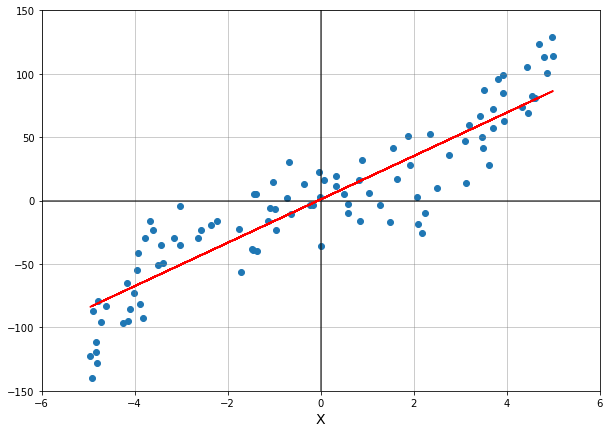

In [39]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split as tts

(Xtrain, Xtest, ytrain, ytest) = tts(X, y, test_size=.75) # split the data for training and testing 

linreg = linear_model.LinearRegression() # create regression object
linreg.fit(Xtrain.reshape(-1,1), ytrain) # fit to the training data

y_pred = linreg.predict(Xtest.reshape(-1,1)) # predict based on the testing data

# Plot this model on the data

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(X,y)
plt.plot(Xtest, y_pred, '-', color='red')

ax.hlines(y=0,xmin=-6,xmax=6, color='black',alpha=.7)
ax.vlines(x=0,ymin=-150,ymax=150, color='black',alpha=.7)

plt.ylim(-150,150)
plt.xlim(-6,6)

plt.xlabel('X',fontsize=14)

ax.grid(which='major', color='grey', alpha = .5)

plt.show()

Visually, not too terrible. Let's check the score though. 

In [36]:
linreg.score(X.reshape(-1,1),y)

0.8184040448977229

Yeah, we can do better. 

Clearly, a linear model won't be able to capture non-linear trends, which is where locally weighted regression comes in. 

Locally weighted regrssion (LOWESS) is sort of like combining many, tiny linear regressions into a smooth (in our case curved) line. 

We are still minimizing the squared error, but we use a *kernel* to weight that error.

A common kernel is the Gaussian curve:

$$ e^{-\frac{(x_i - x_o)^2}{2\tau}}$$

The Gaussean kernel is a standard bell shape, where $\tau$ determines the "width" of the curve.

Applying a kernel means that the weights depend on the particular point where the regression is evaluated - hence "locally weighted". The closer to the point, the more weight it's error is given, and the further from the point the less weight. Exactly *how* far is determined by $\tau$

Heres an example using the statsmodels library:

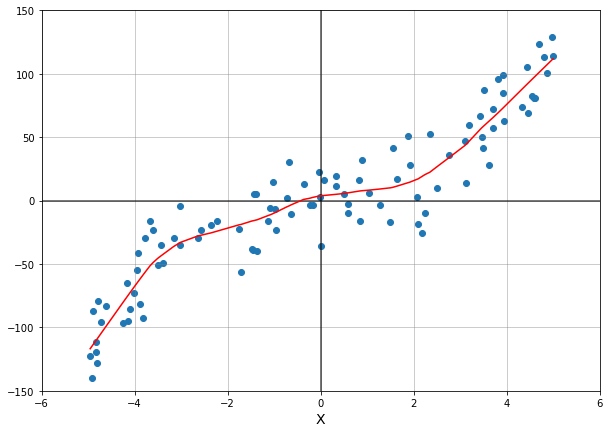

In [42]:

import statsmodels.api as sm
import scipy.stats as stats

# I'll use statsmodel first
lowess = sm.nonparametric.lowess

y_statsmodel = lowess(exog=X,endog=y,frac=.3) # apply lowess

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(X,y)
plt.plot(y_statsmodel[:,0],y_statsmodel[:,1], color='red')

ax.hlines(y=0,xmin=-6,xmax=6, color='black',alpha=.7)
ax.vlines(x=0,ymin=-150,ymax=150, color='black',alpha=.7)

plt.ylim(-150,150)
plt.xlim(-6,6)

plt.xlabel('X',fontsize=14)

ax.grid(which='major', color='grey', alpha = .5)

plt.show()

This model definitely appears much closer to the original $x^3$ function.

I'll apply a different form of LOWESS and compare.

In [43]:
# This is the lowess definition we wrote in class. 

from scipy import linalg

def kernel_function(xi,x0,tau= .005): 
    return np.exp( - (xi - x0)**2/(2*tau))
    
def weights_matrix(x,tau):
  n = len(x)
  return np.array([kernel_function(x,x[i],tau) for i in range(n)]) 

def lowess_bell_shape_kern1(x, y, tau = .005):
    """lowess_bell_shape_kern(x, y, tau = .005) -> the estimate of y denoted "yest"
    Locally weighted regression: fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The kernel function is the bell shaped function with parameter tau. Larger tau will result in a
    smoother curve. 
    """
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    # here w is an nxn matrix
    w = weights_matrix(x,tau)    
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

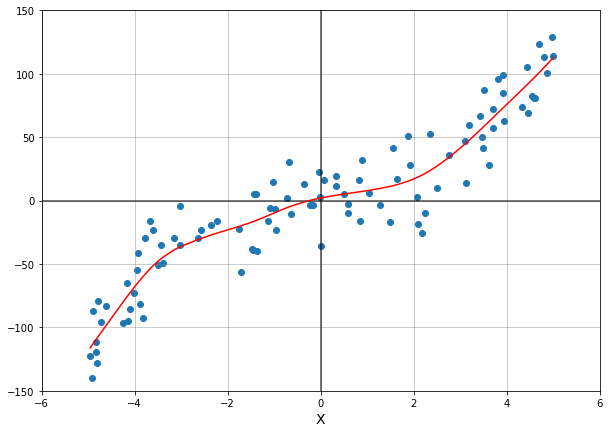

In [49]:
y_lowess = lowess_bell_shape_kern1(X,y,tau=.6) # Play with this tau value

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(X,y)
plt.plot(X[np.argsort(X)], y_lowess[np.argsort(X)], color='red')

ax.hlines(y=0,xmin=-6,xmax=6, color='black',alpha=.7)
ax.vlines(x=0,ymin=-150,ymax=150, color='black',alpha=.7)

plt.ylim(-150,150)
plt.xlim(-6,6)

plt.xlabel('X',fontsize=14)

ax.grid(which='major', color='grey', alpha = .5)

plt.show()

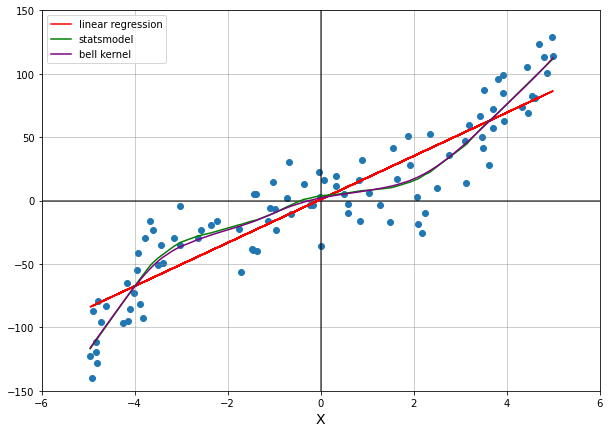

In [56]:
## Lets plot all three of these models on the data

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(X,y)
plt.plot(Xtest, y_pred, '-', color='red', label='linear regression')
plt.plot(y_statsmodel[:,0],y_statsmodel[:,1], color='green', label='statsmodel')
plt.plot(X[np.argsort(X)], y_lowess[np.argsort(X)], color='purple', label='bell kernel')

ax.hlines(y=0,xmin=-6,xmax=6, color='black',alpha=.7)
ax.vlines(x=0,ymin=-150,ymax=150, color='black',alpha=.7)

plt.ylim(-150,150)
plt.xlim(-6,6)

plt.xlabel('X',fontsize=14)
plt.legend()

ax.grid(which='major', color='grey', alpha = .5)

plt.show()


Hopefully it is clear that the two forms of LOWESS model this data better than a linear regression. From this point, we can cross validate the data, try different tau values, use different kernels, model multidimensional data, and hopefully find the best possible model.